## CREDIT CARD FRUAD DETECTION
Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Inspiration

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Data reading and exploration

In [1]:
# Importing the important libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Since the features V1 to V28 columns are generated from a PCA the only meaningful columns will be analysed using univariate and multivariate distributions. 

In [4]:
df = data[['Time','Amount', 'Class']]

In [5]:
df

,Time,Amount,Class
0,0.0,149.62,0
1,0.0,2.69,0
2,1.0,378.66,0
3,1.0,123.50,0
4,2.0,69.99,0
...,...,...,...
284802,172786.0,0.77,0
284803,172787.0,24.79,0
284804,172788.0,67.88,0
284805,172788.0,10.00,0


In [6]:
df.describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


In [7]:
df.isna().sum()

Time      0
Amount    0
Class     0
dtype: int64

In [8]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

The records classified as fraudulent are outnumbered by those classified as non-fraudulent. This would be address before building the data models

In [9]:
warnings.filterwarnings('ignore')

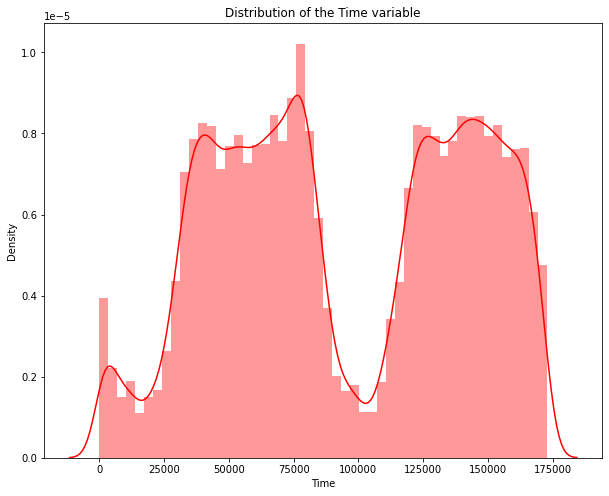

In [10]:
plt.figure(figsize=(10,8))
plt.title('Distribution of the Time variable')
sns.distplot(df['Time'], color='red');

The distribution is bimodal with the most records occuring at approximately at 75000 and 150000 seconds after the first transaction

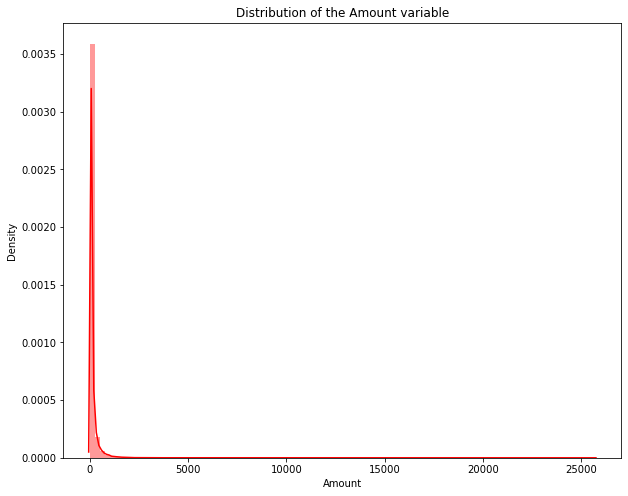

In [11]:
plt.figure(figsize=(10,8))
plt.title('Distribution of the Amount variable')
sns.distplot(df['Amount'], color='red', bins=100);

The majority of the transaction amounts are below 5000 and sharply decreases

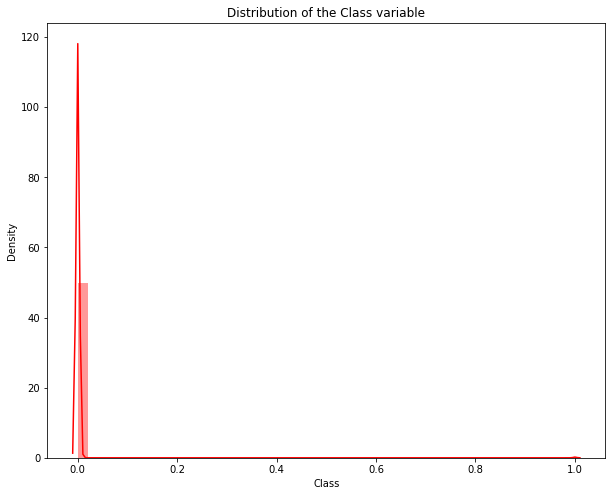

In [12]:
plt.figure(figsize=(10,8))
plt.title('Distribution of the Class variable')
sns.distplot(df['Class'], color='red');

The relationship between the columns are explored below using pair plots and correlation plots.

<Figure size 720x576 with 0 Axes>

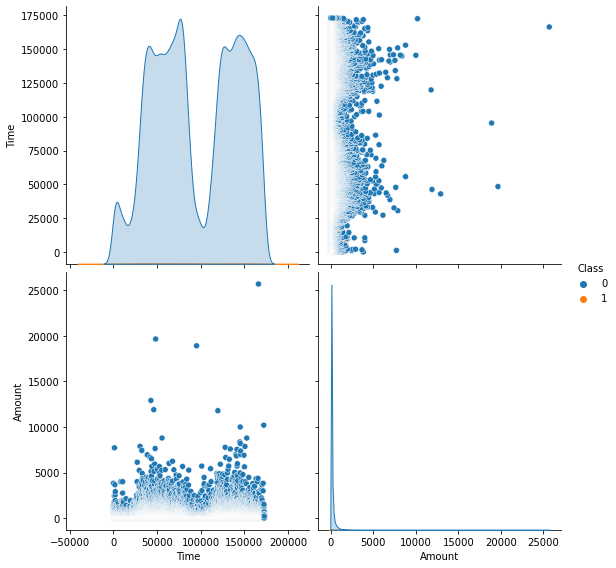

In [13]:
plt.figure(figsize=(10,8))
sns.pairplot(df, hue='Class', height=4, aspect=1, diag_kind='kde');

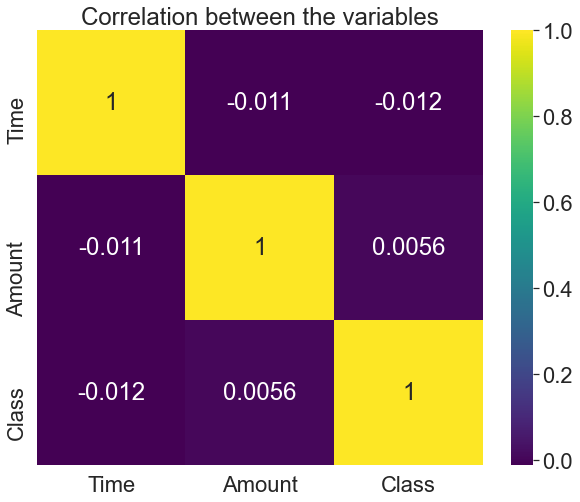

In [14]:
plt.figure(figsize=(10,8))
sns.set(font_scale=2)
plt.title('Correlation between the variables')
sns.heatmap(df.corr(), annot=True, cmap='viridis');

There are no strong relationships between the variables. The other variables due to their PCA transformation have no strong correlations among themselves 

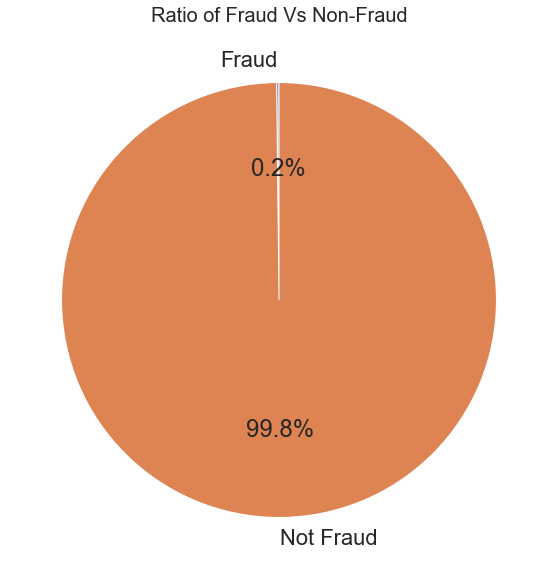

In [15]:
fraud =len(df[df['Class']==1])
notfraud = len(df[df['Class']==0])
sizes = [fraud, notfraud]
labels = 'Fraud', 'Not Fraud'

plt.figure(figsize=(16,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Ratio of Fraud Vs Non-Fraud', fontsize=20)
sns.set_context("paper", font_scale=2);

## Data preprocessing

The dataset will be split into predictors X and target Y variables and then into the training and testing datasets to be used for building the data models

In [16]:
X = data.drop(labels='Class', axis=1)
Y = data['Class']

In [17]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.70, random_state=1)

In [19]:
train_data = pd.concat([X_train, Y_train], axis=1)

## Verifying the inbalance of the data's Class column

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_fit = dummy_model.fit(X_train, Y_train)

In [22]:
print('The accuracy of the most frequent label',sum(dummy_fit.predict(X_test) == Y_test) / len(X_test))

The accuracy of the most frequent label 0.9984199992977775


In [23]:
print('The predicted most frequent label', np.unique(dummy_fit.predict(X_test)))

The predicted most frequent label [0]


## Handling the data inbalance

This can be done by oversampling the minority class (the fraudulent records), undersampling the majority class (the non-fraudulent records or using the SMOTE technique (Synthetic Minority Oversampling Technique). SMOTE uses the mniority class to generate artifical data points to match the number of data points the majority class. 

#### Undersampling 

In [24]:
from sklearn.utils import resample

In [25]:
fraud = train_data[train_data['Class']==1]
no_fraud = train_data[train_data['Class']==0]

undersample_data = resample(no_fraud, n_samples=len(fraud), random_state=1)
undersample_ = pd.concat([fraud,undersample_data])
print('Total count of the undersampled data', undersample_.shape[0],'\n')
print('The count of undersampled class records', '\n',undersample_['Class'].value_counts())

Total count of the undersampled data 714 

The count of undersampled class records 
 0    357
1    357
Name: Class, dtype: int64


In [26]:
# Fitting a logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix
lr_model = LogisticRegression()

In [27]:
x_train = undersample_.drop('Class', axis=1)
y_train = undersample_['Class']
lr_model.fit(x_train, y_train)

LogisticRegression()

In [28]:
pred = lr_model.predict(X_test)
print('The prediction accuracy for the undersampled data:',accuracy_score(Y_test, pred))

The prediction accuracy for the undersampled data: 0.9703545053427431


In [29]:
print('The Logistics regression classification report')
print('-'*50)
print(classification_report(Y_test, pred))

The Logistics regression classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85308
           1       0.04      0.87      0.08       135

    accuracy                           0.97     85443
   macro avg       0.52      0.92      0.53     85443
weighted avg       1.00      0.97      0.98     85443



In [30]:
pd.DataFrame(confusion_matrix(Y_test, pred))

,0,1
0,82793,2515
1,18,117


#### Oversampling

In [31]:
oversample_data = resample(fraud, n_samples=len(no_fraud), random_state=1)
oversample_ = pd.concat([no_fraud,oversample_data])
print('Total count of the oversampled data', oversample_.shape[0],'\n')
print('The count of oversampled class records', '\n',oversample_['Class'].value_counts())

Total count of the oversampled data 398014 

The count of oversampled class records 
 0    199007
1    199007
Name: Class, dtype: int64


In [32]:
lrg_model = LogisticRegression()

x_train = oversample_.drop('Class', axis=1)
y_train = oversample_['Class']
lrg_model.fit(x_train, y_train)

LogisticRegression()

In [33]:
pred = lrg_model.predict(X_test)
print('The prediction accuracy for the oversampled data:',accuracy_score(Y_test, pred))

The prediction accuracy for the oversampled data: 0.9707641351544304


In [34]:
print('The Logistics regression classification report')
print('-'*50)
print(classification_report(Y_test, pred))

The Logistics regression classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85308
           1       0.05      0.87      0.09       135

    accuracy                           0.97     85443
   macro avg       0.52      0.92      0.54     85443
weighted avg       1.00      0.97      0.98     85443



In [35]:
pd.DataFrame(confusion_matrix(Y_test, pred))

,0,1
0,82828,2480
1,18,117


#### SMOTE resampling

In [36]:
from imblearn.over_sampling import SMOTE

In [37]:
sm = SMOTE(random_state=27)
X_train1, Y_train1 = sm.fit_resample(X_train, Y_train)

In [38]:
log_reg = LogisticRegression()
log_reg.fit(X_train1, Y_train1)

LogisticRegression()

In [39]:
pred = log_reg.predict(X_test)
print('The prediction accuracy for the SMOTE resampled data:',accuracy_score(Y_test, pred))

The prediction accuracy for the SMOTE resampled data: 0.983146659176293


In [40]:
print('The Logistics regression classification report')
print('-'*50)
print(classification_report(Y_test, pred))

The Logistics regression classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85308
           1       0.07      0.84      0.14       135

    accuracy                           0.98     85443
   macro avg       0.54      0.91      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [41]:
pd.DataFrame(confusion_matrix(Y_test, pred))

,0,1
0,83889,1419
1,21,114


The SMOTE resampling technique provides the best results. It will be used to train classifier algorithms and their performances will be compared to choose the best for classifying fraudulent and no fradulent transactions especially in terms of having the least false Negative rate i.e. classifying fradulent transactions as non fraudulent

In [42]:
# Trying a randomforest classfier 

from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier()
rfc_fit = rfc_model.fit(X_train1,Y_train1)

In [43]:
pred = rfc_fit.predict(X_test)
print('The accuracy score for Random Forest Classifier', accuracy_score(Y_test, pred))

The accuracy score for Random Forest Classifier 0.9994850368081645


In [44]:
print('The Random Forest classification report')
print('-'*50)
print(classification_report(Y_test, pred))

The Random Forest classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.86      0.80      0.83       135

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [45]:
pd.DataFrame(confusion_matrix(Y_test, pred))

,0,1
0,85291,17
1,27,108


In [46]:
# Trying a naive bayes classifier

from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_fit = nb_model.fit(X_train1,Y_train1)

In [47]:
pred = nb_fit.predict(X_test)
print('The accuracy score for the Naive Bayes', accuracy_score(Y_test,pred))

The accuracy score for the Naive Bayes 0.9923925892115212


In [66]:
print('The Naive Bayes classification report')
print('-'*50)
print(classification_report(Y_test, pred))

The Naive Bayes classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.80      0.81      0.81       135

    accuracy                           1.00     85443
   macro avg       0.90      0.91      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [49]:
pd.DataFrame(confusion_matrix(Y_test, pred))

,0,1
0,84695,613
1,37,98


In [50]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_fit = xgb_model.fit(X_train1, Y_train1)

[20:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
pred = xgb_fit.predict(X_test)
print('The accuracy for XGBoost Classifier', accuracy_score(Y_test, pred))

The accuracy for XGBoost Classifier 0.9993797034280163


In [67]:
print('The XGBoost classification report')
print('-'*50)
print(classification_report(Y_test, pred))

The XGBoost classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.80      0.81      0.81       135

    accuracy                           1.00     85443
   macro avg       0.90      0.91      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [53]:
pd.DataFrame(confusion_matrix(Y_test, pred))

,0,1
0,85280,28
1,25,110


## Plotting the AUC curve for each classifier

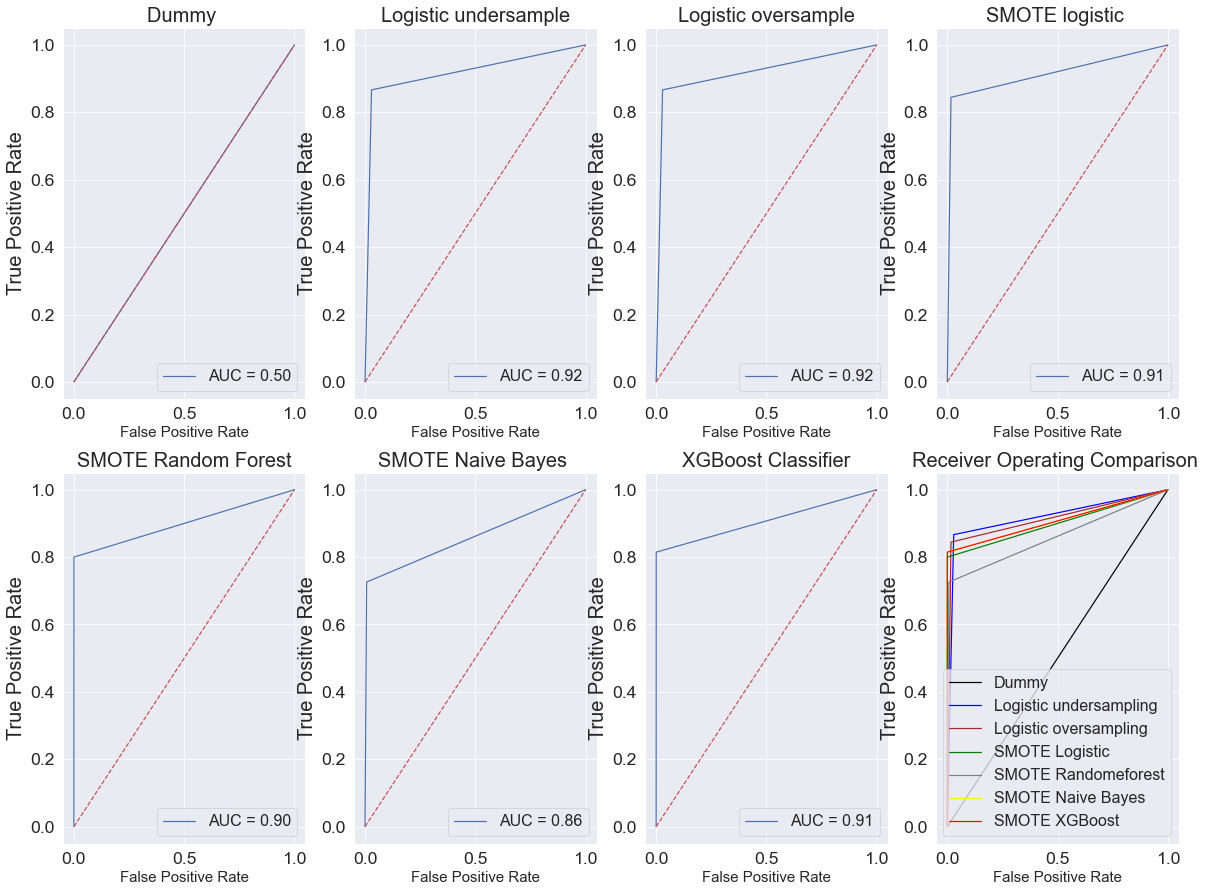

In [71]:
from sklearn.metrics import * 
fig, ax_arr = plt.subplots(nrows = 2, ncols = 4, figsize = (20,15))


#----------Dummy---------


dummy_pred = dummy_model.predict(X_test)
fprdm, tprdm, thresholddm = roc_curve(Y_test,dummy_pred)
roc_aucxgb = auc(fprdm,tprdm)

ax_arr[0,0].plot(fprdm,  tprdm, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('Dummy ',fontsize=20)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})


# ----------Logistic undersampling---------

undersampled_pred = lr_model.predict(X_test)
fprlog, tprlog, thresholdlog = roc_curve(Y_test, undersampled_pred)
roc_aucxgb = auc(fprlog, tprlog)

ax_arr[0,1].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,1].plot([0, 1], [0, 1],'r--')
ax_arr[0,1].set_title('Logistic undersample',fontsize=20)
ax_arr[0,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,1].legend(loc = 'lower right', prop={'size': 16})


# ----------Logistic oversampling---------

oversampled_pred = lrg_model.predict(X_test)
fprlog, tprlog, thresholdlog = roc_curve(Y_test, oversampled_pred)
roc_aucxgb = auc(fprlog, tprlog)

ax_arr[0,2].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,2].plot([0, 1], [0, 1],'r--')
ax_arr[0,2].set_title('Logistic oversample',fontsize=20)
ax_arr[0,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,2].legend(loc = 'lower right', prop={'size': 16})


#----------SMOTE logistic---------


smote_pred = log_reg.predict(X_test)
#preds = probs[:,1]
fprsm, tprsm, thresholdsm = roc_curve(Y_test, smote_pred)
roc_aucxgb = auc(fprsm, tprsm)


ax_arr[0,3].plot(fprsm, tprsm, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[0,3].plot([0, 1], [0, 1],'r--')
ax_arr[0,3].set_title('SMOTE logistic ',fontsize=20)
ax_arr[0,3].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,3].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,3].legend(loc = 'lower right', prop={'size': 16})



#---------- SMOTE Randomforest---------

rnd_pred = rfc_model.predict(X_test)
#preds = probs[:,1]
fprgnb, tprgnb, thresholdgnd = roc_curve(Y_test, rnd_pred)
roc_aucxgb = auc(fprgnb, tprgnb)


ax_arr[1,0].plot(fprgnb, tprgnb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[1,0].plot([0, 1], [0, 1],'r--')
ax_arr[1,0].set_title('SMOTE Random Forest',fontsize=20)
ax_arr[1,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,0].legend(loc = 'lower right', prop={'size': 16})


#----------SMOTE GaussianNB---------


nab_pred = nb_model.predict(X_test)
#preds = probs[:,1]
fprfst, tprfst, thresholdfst = roc_curve(Y_test, nab_pred)
roc_aucxgb = auc(fprfst, tprfst)


ax_arr[1,1].plot(fprfst, tprfst, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[1,1].plot([0, 1], [0, 1],'r--')
ax_arr[1,1].set_title('SMOTE Naive Bayes ',fontsize=20)
ax_arr[1,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,1].legend(loc = 'lower right', prop={'size': 16})


#----------XGBoost Classifier---------


xgb_pred = xgb_model.predict(X_test)
fprgsv, tprgsv, thresholdgsv = roc_curve(Y_test, xgb_pred)
roc_aucxgb = auc(fprgsv,  tprgsv)


ax_arr[1,2].plot(fprgsv,  tprgsv, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax_arr[1,2].plot([0, 1], [0, 1],'r--')
ax_arr[1,2].set_title('XGBoost Classifier',fontsize=20)
ax_arr[1,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,2].legend(loc = 'lower right', prop={'size': 16})


#----------ALL---------


ax_arr[1,3].plot(fprdm, tprdm, 'b', label = 'Dummy', color='black')
ax_arr[1,3].plot(fprlog, tprlog, 'b', label = 'Logistic undersampling', color='blue')
ax_arr[1,3].plot(fprsm, tprsm, 'b', label = 'Logistic oversampling', color='brown')
ax_arr[1,3].plot(fprgnb, tprgnb, 'b', label = 'SMOTE Logistic', color='green')
ax_arr[1,3].plot(fprfst, tprfst, 'b', label = 'SMOTE Randomeforest', color='grey')
ax_arr[1,3].plot(fprgsv,  tprgsv, 'b', label = 'SMOTE Naive Bayes', color='yellow')
ax_arr[1,3].plot(fprgsv,  tprgsv, 'b', label = 'SMOTE XGBoost', color='red')
ax_arr[1,3].set_title('Receiver Operating Comparison ',fontsize=20)
ax_arr[1,3].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,3].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,3].legend(loc = 'lower right', prop={'size': 16})

Based on the combination of sampling technique and classification model used for making classification as well as the classification report and the confusion matrix showing the least false negative rate XGBoost classifier had the best performance with a 91% accuracy predicting fradulaent transactions as fradulent and non fraudulent as non fradulent. 


The undersampling and oversampling techniques are 1% better comparing its AUC performance to XGBoost however they do not perform well based on F1 score, precision and recall. Recall measures the model's ability to predict correct fraudulent transactions 
as fraudulent given both fraudulent and incorrect non fraudulent predictions while precision is the ability of a given model to predict correct fraudulent transactions given both correct fraudulent and incorrect fraudulent transactions.
